<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Data Preprocessing

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#stats stuff
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split

## Load Data

In [69]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [126]:
df.columns = df.columns.map(lambda x: x.replace(' ','_'))

In [127]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Check for Multicollinearity

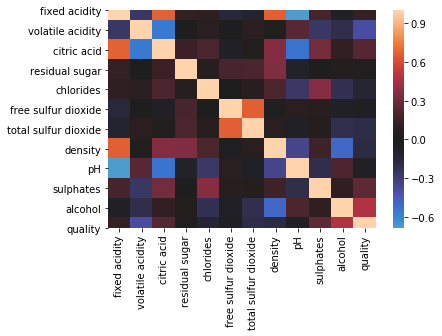

In [10]:
sns.heatmap(df.corr(),center=0);

In [220]:
(abs(df.corr()) > 0.75).sum()

fixed_acidity           1
volatile_acidity        1
citric_acid             1
residual_sugar          1
chlorides               1
free_sulfur_dioxide     1
total_sulfur_dioxide    1
density                 1
pH                      1
sulphates               1
alcohol                 1
quality                 1
dtype: int64

These two above cells confirm no multicollinearity to worry about.

## Visualize for Non-Transformed Data

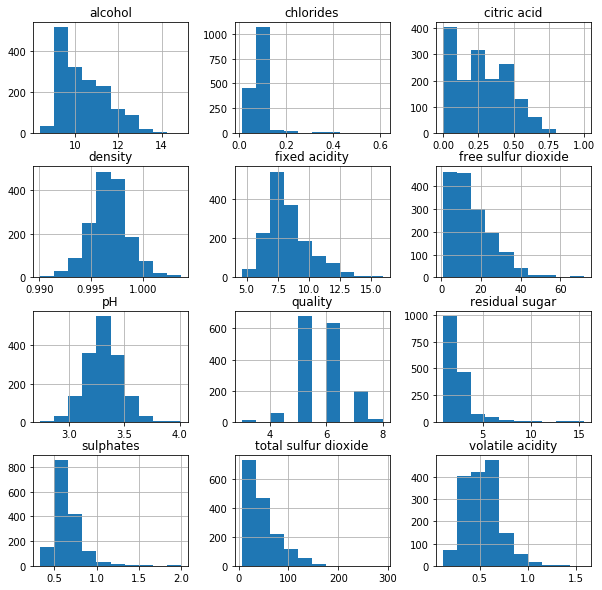

In [13]:
df.hist(figsize  = [10, 10]); 

The above visuals show that density and pH are already normally-distributed. Others will need to be log transformed. Several columns have values between 0 and 1, and thus will need to be transformed according to log(x+1).

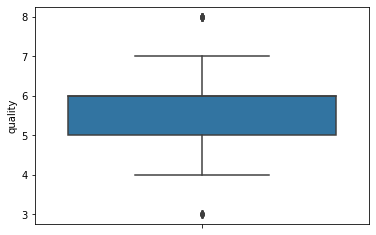

In [118]:
sns.boxplot(y=df.quality)

The quality column has mostly values at 5 or 6, which probably won't tell us much about any of the other variables. We therefore will omit this from our exploration.

## Log Transform

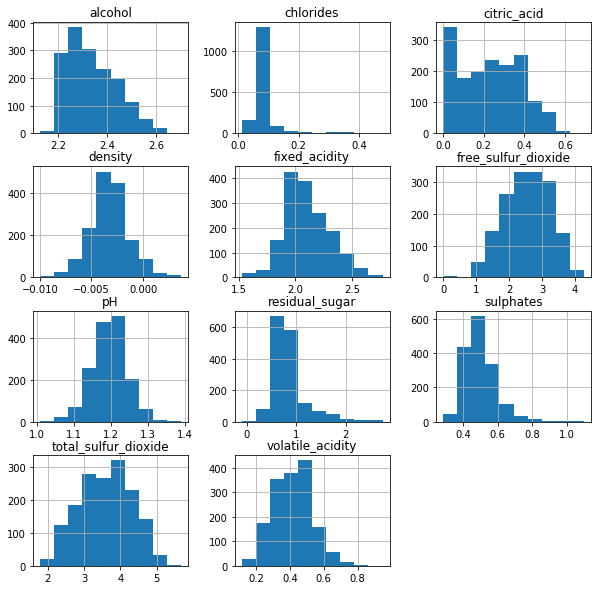

In [128]:
# Create log-transformed DF
df_log = pd.DataFrame([])

# Keep track of which categories to apply which transformations to (The slicing gets rid of the quality column)
cats = df.columns[:-1]
non_log_cats = ['pH','density']
offset_log_cats = ['citric_acid','free_sulphur_dioxide','chlorides','volatile_acidity', 'sulphates']

# Iterate
for cat in cats:
    
    # Don't transform already normally-distributed data
    if cat in non_log_cats:
        df_log[cat] = df[cat]
        
    # Add 1 and THEN log transform columns containing values between [0,1)
    if cat in offset_log_cats:
        df_log[cat] = np.log(df[cat] + 1)
    
    # Log transform everything else
    else:
        df_log[cat] = np.log(df[cat])


df_log.hist(figsize  = [10, 10]);

## Feature Scaling

We are going to min-max scale to get our data between 0 and 1 for multiple linear regression.

In [129]:
y = df[["alcohol"]]
X = df_log #.drop(labels='alcohol',axis=1)

scale = MinMaxScaler()
transformed = scale.fit_transform(X)
X = pd.DataFrame(transformed, columns = X.columns)

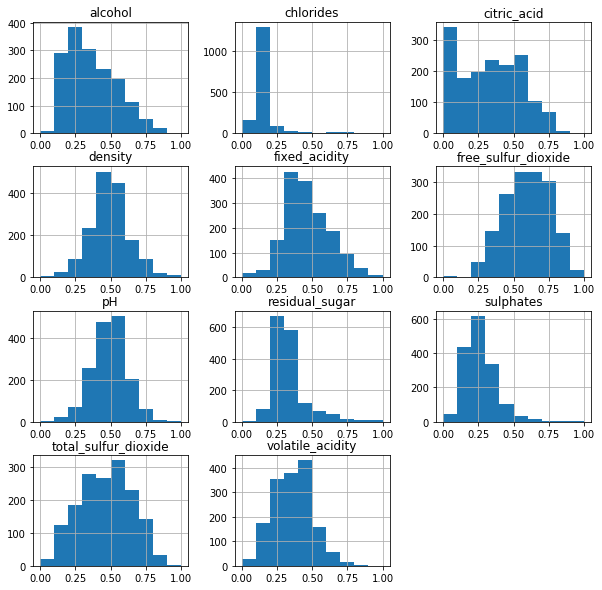

In [130]:
X.hist(figsize  = [10, 10]);

# Statistical Modeling

In [131]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [132]:
data_ols = X
data_ols.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.383325,0.500083,0.000000,0.262530,0.131896,0.560693,0.447677,0.569223,0.650306,0.196091,0.196252
1,0.425771,0.620692,0.000000,0.372733,0.175429,0.752660,0.622746,0.495834,0.407509,0.287196,0.268963
2,0.425771,0.541649,0.056584,0.329657,0.163644,0.633215,0.567074,0.510518,0.456287,0.265045,0.268963
3,0.717475,0.160021,0.641546,0.262530,0.129896,0.662482,0.594267,0.583892,0.374479,0.211752,0.268963
4,0.383325,0.500083,0.000000,0.262530,0.131896,0.560693,0.447677,0.569223,0.650306,0.196091,0.196252


In [133]:
# Create the formula of form "outcome ~ predictor_1+predictor_2+...+predictor_n"
data_ols = X
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     345.5
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:30:28   Log-Likelihood:                 1464.8
No. Observations:                1599   AIC:                            -2908.
Df Residuals:                    1588   BIC:                            -2849.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0337      0.029     -1.165      0.244      -0.091       0.023
fixed_acidity            0.9113      0.036     25.144      0.000       0.840       0.982
volatile_acidity         0.0776      0.024      3.231      0.001       0.030       0.125
citric_acid              0.1104      0.019      5.760      0.000       0.073       0.148
residual_sugar           0.6064      0.022     27.392      0.000       0.563       0.650
chlorides               -0.1440      0.034     -4.176      0.000      -0.212      -0.076
free_sulfur_dioxide      0.0085      0.026      0.329      0.742      -0.042       0.059
total_sulfur_dioxide    -0.0988      0.024     -4.159      0.000      -0.145      -0.052
density                 -1.4018      0.031    -45.484      0.000      -1.462      -1.341
pH                       0.7608      0.032     23.752      0.000       0.698       0.824
sulphates                0.3367      0.024     14.006      0.000       0.290       0.384
==============================================================================
Omnibus:                      141.267   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.108
Skew:                           0.620   Prob(JB):                     1.62e-53
Kurtosis:                       4.454   Cond. No.                         38.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that $p_\text{free sulfur dioxide} > \alpha$ so we will eliminate this predictor from the model. Also, free sulfur dioxide is accounted for in total sulfur dioxide, so we don't really lose much by eliminating this predictor.

In [134]:
X.drop('free_sulfur_dioxide',axis=1,inplace=True)

## Take 2

In [135]:
# Create the formula of form "outcome ~ predictor_1+predictor_2+...+predictor_n"
data_ols = X
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     384.0
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:33:32   Log-Likelihood:                 1464.8
No. Observations:                1599   AIC:                            -2910.
Df Residuals:                    1589   BIC:                            -2856.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0319      0.028     -1.123      0.262      -0.088       0.024
fixed_acidity            0.9131      0.036     25.488      0.000       0.843       0.983
volatile_acidity         0.0765      0.024      3.217      0.001       0.030       0.123
citric_acid              0.1093      0.019      5.788      0.000       0.072       0.146
residual_sugar           0.6070      0.022     27.507      0.000       0.564       0.650
chlorides               -0.1436      0.034     -4.169      0.000      -0.211      -0.076
total_sulfur_dioxide    -0.0926      0.014     -6.398      0.000      -0.121      -0.064
density                 -1.4037      0.030    -46.330      0.000      -1.463      -1.344
pH                       0.7624      0.032     24.087      0.000       0.700       0.824
sulphates                0.3371      0.024     14.046      0.000       0.290       0.384
==============================================================================
Omnibus:                      140.635   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.425
Skew:                           0.618   Prob(JB):                     3.76e-53
Kurtosis:                       4.447   Cond. No.                         35.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Intercept p value is still $> \alpha$ but we will proceed for now.

In [191]:
def compare_fits(X,y,test_size=0.2, alpha=0.5):
    """
    Print out fit comparisons between linear, ridge, and lasso regressions.
    
    Param X: predictors
    Param y: outcome
    Param test_size: percentage of data set to be used as the test sample
    Param alpha: hyperparameter for ridge and lasso. Must be [0,1].
    """
    # Perform test train split
    X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

    # Build a Ridge, Lasso and regular linear regression model. 
    # Note how in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    lin = LinearRegression()
    lin.fit(X_train, y_train)
    
#     print("Unpenalized Linear Regression Coefficients are:{}".format(dict(zip(X.columns,lin.coef_[0]))))
#     print("\nUnpenalized Linear Regression Intercept:{}".format(lin.intercept_))
#     print('\n')
#     print("\nLasso Regression Coefficients are:{}".format(dict(zip(X.columns,lasso.coef_))))
#     print("\nLasso Linear Regression Intercept:{}".format(lasso.intercept_))
#     print('\n')
#     print("\nRidge Regression Coefficients are:{}".format(dict(zip(X.columns,ridge.coef_[0]))))
#     print("\nRidge Linear Regression Intercept:{}".format(ridge.intercept_))
#     print('\n')
    # create predictions
    y_h_ridge_train = ridge.predict(X_train)
    y_h_ridge_test = ridge.predict(X_test)

    y_h_lasso_train = np.reshape(lasso.predict(X_train),(1279,1))
    y_h_lasso_test = np.reshape(lasso.predict(X_test),(320,1))

    y_h_lin_train = lin.predict(X_train)
    y_h_lin_test = lin.predict(X_test)
    
    # examine the residual sum of sq
#     print('---------------------------------------')
#     print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train)**2))
#     print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test)**2))
#     print('\n')

#     print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train)**2))
#     print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test)**2))
#     print('\n')

#     print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train))**2))
#     print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test))**2))
    
    train_error_ridge = np.sum((y_train - y_h_ridge_train)**2)
    test_error_ridge = np.sum((y_test - y_h_ridge_test)**2)
    
    train_error_linear = np.sum((y_train - lin.predict(X_train))**2)
    test_error_linear = np.sum((y_test - lin.predict(X_test))**2)
    
    return [train_error_ridge[0], test_error_ridge[0], train_error_linear[0], test_error_linear[0]]

In [199]:
[0.1] + compare_fits(X,y,test_size=0.2)

[0.1,
 5.227175282293192,
 0.9452860287908595,
 4.691960484962457,
 0.8988629367189843]

In [204]:
data = [[round(x,1)] + compare_fits(X,y,test_size=0.2, alpha=x) for x in np.arange(0.1, 1, 0.1)]

fits_df = pd.DataFrame(data,columns = ['alpha','train_error_ridge','test_error_ridge','train_error_linear','test_error_linear'])

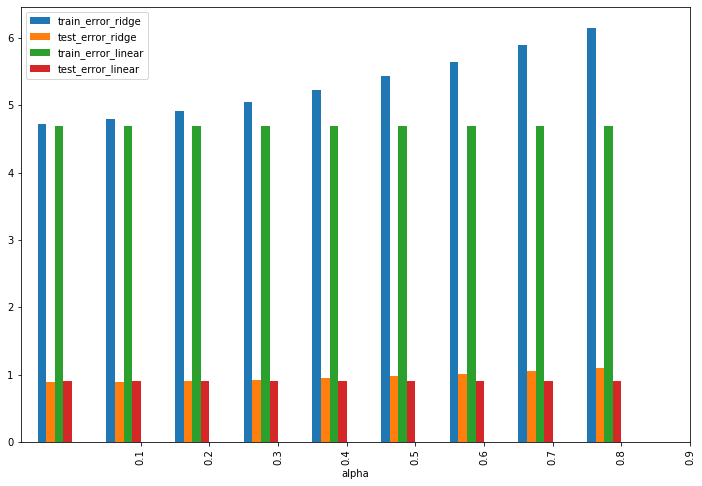

In [209]:
fits_df.plot(x='alpha',kind='bar',position=3,figsize=(12,8))

The nonpenalized model is superior to the penalized linear models.